In [136]:
import pandas as pd
%matplotlib inline

import math
import scipy.stats as stats

import numpy as np
import matplotlib.pyplot as plt

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportions_chisquare

import seaborn as sns
sns.set(color_codes=True)

from datetime import timedelta
import datetime
import time
import os

In [137]:
# Цвета для виз
color_hex_list = ['#88CCEE', '#CC6677', '#DDCC77', '#117733', '#332288', '#E58606',  '#999933', '#882255', '#661100', 
 '#5D69B1', '#52BCA3', '#99C945', '#CC61B0', '#24796C', '#DAA51B', '#2F8AC4', '#764E9F', '#ED645A']

---

# НАСТРОЙКИ ДО ТЕСТА

## Размер группы

Если вы не хотите считать сами, воспользуйтесь готовы решением на сайте: [ссылка](https://www.evanmiller.org/ab-testing/sample-size.html)

In [138]:
# установка базовых переменных
baseline_probability = 0.10
beta = 0.2
alpha = 0.05
effectSize = 0.01

# определяем one-side или two-side тест
one_sided = True 

#### Рассчитаем стартовые данные 

In [139]:
alpha_Zscore = stats.norm.ppf(1-alpha*(1-0.5*(1-one_sided)))
beta_Zscore = stats.norm.ppf(1-beta)

print('Baseline Conversion (pr) = ', baseline_probability*100, '%')
print('Confidence Level = ', (1-alpha)*100, '%')
print('Alpha Z-score (za) = ', round(alpha_Zscore,2))
print('Power = ', (1-beta)*100, '%')
print('Beta Z-score (zb) = ', round(beta_Zscore,2))
print('Effect Size (E) = ', effectSize*100, '%')

Baseline Conversion (pr) =  10.0 %
Confidence Level =  95.0 %
Alpha Z-score (za) =  1.64
Power =  80.0 %
Beta Z-score (zb) =  0.84
Effect Size (E) =  1.0 %


#### Функция установки "траффика", который будет проходить через модель

In [140]:
def sample_size(E, za, zb, pr):
    variance = pr*(1-pr)  # эту часть можно заменить на baseline по модели
    z = (za+zb)**2
    top = 2*variance*z
    bottom = E**2
    n = top/bottom
    return n

n = sample_size(effectSize, alpha_Zscore, beta_Zscore, baseline_probability)
print('Sample Size (per variation)=',round(n,0))

Sample Size (per variation)= 11129.0


## Определяем минимальный значимый эффект

- расчет на основе alpha / beta / размер группы
- для обнаружения минимального эффекта, мы должны заранее определить размер группы (максимальный)

In [141]:
# функция оценки эффекта
def measurable_effect_size(n, za, zb, pr):
    variance = pr*(1-pr)  # эту часть можно заменить на baseline по модели
    z = (za+zb)**2
    top = 2*variance*z
    bottom = n
    E = math.sqrt(top/n)
    return E

# минимальный эффект
measurable_effect_size(n, alpha_Zscore, beta_Zscore, baseline_probability)

0.01

## Alpha Cutoff 

Сделаем обработку параметра Alpha на количество ожидаемых значений (для классификации), важно для ошибки первого рода. 

Мы считаем - Familywise Error Rate (Alpha Inflation)

In [142]:
# количество сегментов для сравнения (кол-во значений в таргите)
segments = 2

In [144]:
# вероятность ошибки в тести, определеяем для действия - alpha cutoff

1 - (1-alpha)**segments

0.09750000000000003

In [145]:
print("Допустимые коррекции:")
print("Тестирование гипотез на уровне α∗ = (α/segments) = ({a}/{seg}) = {aseg} (где {seg} - кол-во сегментов в группе).".format(a=alpha, seg=segments, aseg = alpha/segments))
print("Гарантированная ошибка 1 типа не будет привышать α = {}".format(round((1 - (1-alpha)**segments),3)))
print("However, this adjustment may be too conservative.")

Допустимые коррекции:
Тестирование гипотез на уровне α∗ = (α/segments) = (0.05/2) = 0.025 (где 2 - кол-во сегментов в группе).
Гарантированная ошибка 1 типа не будет привышать α = 0.098
However, this adjustment may be too conservative.


---

## Данные

Для теста надо иметь в данных следующее:

- id пользователя 
- дата
- тип группы 
- параметры для сравнения

In [146]:
file_name = 'Data/sd.csv'
date_sort = 'date_visit'

# загрузим
data = pd.read_csv(file_name,
                  converters= {date_sort: pd.to_datetime} )
df = data.copy()
df = df.sort_values(date_sort, ascending = True)
df = df[df['version'].isin(['A1', 'A2'])]

# Определение конверсий
traffic_label = 'clicked'
conversion_label = 'liked'

# Группировка
user_label = 'user_id'
date_label = 'date_visit'
segment_label = 'version'

segment_list = list(df[segment_label].unique())

df.head()

,user_id,date_joined,date_visit,version,type,category,visits,clicked,clicks,liked,likes
312,31098584,2018-04-27,2018-04-23,A1,1,NaN,1,1,1,0,0
310,31098581,2018-04-27,2018-04-23,A2,0,NaN,1,1,2,1,5
309,31098580,2018-04-27,2018-04-23,A1,0,NaN,1,1,1,0,0
307,31098577,2018-04-27,2018-04-23,A2,1,NaN,1,1,4,0,0
314,31098589,2018-04-27,2018-04-23,A2,1,M,1,1,5,0,0


#### Обзор сегментов

In [147]:
variations = len(segment_list)
print('Different segments: ',segment_list)
print('Number of segments: ', variations)

Different segments:  ['A1', 'A2']
Number of segments:  2


### Траффик по дням

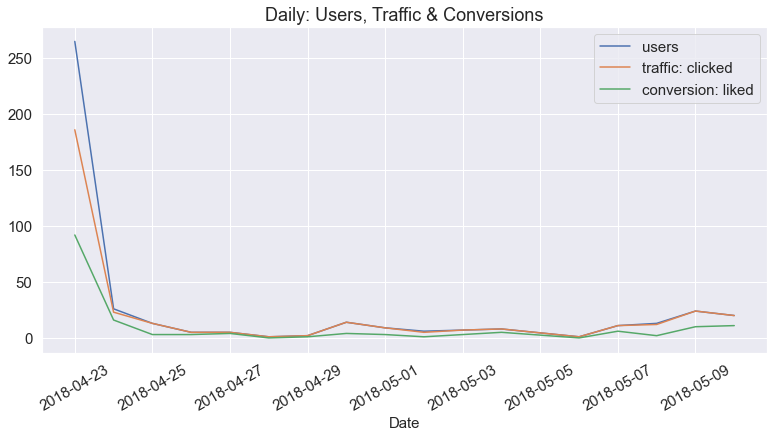

In [148]:
# Агрегат по дню
daily_users = pd.DataFrame(d2.groupby(date_label)[user_label].nunique()).reset_index()
daily_traffic = pd.DataFrame(d2.groupby(date_label)[traffic_label].sum()).reset_index()
daily_conversions = pd.DataFrame(d2.groupby(date_label)[conversion_label].sum()).reset_index()


# Визуализируем
plt.subplots(figsize=(13, 6))
plt.plot(pd.to_datetime(daily_users[date_label]), daily_users[user_label], label = 'users')
plt.plot(pd.to_datetime(daily_traffic[date_label]), daily_traffic[traffic_label], label = ('traffic: ' + traffic_label))
plt.plot(pd.to_datetime(daily_conversions[date_label]), daily_conversions[conversion_label], label = ('conversion: ' + conversion_label))
plt.xlabel('Date', fontsize=15)
plt.xticks(fontsize=15, rotation=30)
plt.yticks(fontsize=15)
plt.title('Daily: Users, Traffic & Conversions', fontsize=18)
plt.legend(fontsize=15)
plt.show()

In [149]:
# Conversion Rate
round((daily_conversions[conversion_label]/daily_traffic[traffic_label]).mean()*100,2)

40.43

In [150]:
# Average Traffic / User
round((daily_traffic[traffic_label]/daily_users[user_label]).mean(),2)

0.96

In [151]:
# Average Conversions / User
round((daily_conversions[conversion_label]/daily_users[user_label]).mean(),2)

0.39

### Таблица сегментов

In [152]:
# выделение колонок для агрегата'traffic' / 'conversion'
aggregation_column = [traffic_label, conversion_label]
traffic = []
conversions = [] 

# расчет агрегатов
for i in range(variations):
    v, c = df[df[segment_label] == segment_list[i] ][aggregation_column[:2]].sum()

    traffic.append(v)
    conversions.append(c)
    
    
# новый DF   
dfp_simple = pd.DataFrame({
    "converted": conversions,
    "traffic": traffic
}, index = segment_list)

dfp_simple

#dfp = dfp_simple.copy().sort_index()

,converted,traffic
A1,42,86
A2,37,88


In [153]:
dfp = dfp_simple.copy().sort_index()

# Сумма по всем колонкам
dfp.loc['Total'] = dfp.sum()

# определение не сконвертируемых
dfp['not_converted'] = dfp['traffic'] - dfp['converted']

# отношение конвертируемых к траффику
proportion = dfp.converted/dfp.traffic
dfp['converted_proportion'] = proportion

# STD
dfp['standard_error'] = ((proportion * (1-proportion))/dfp.traffic)**(.5)

# % траффика
n = dfp.loc['Total']['traffic']
dfp['population_percentage'] = dfp['traffic']/n

dfp

,converted,traffic,not_converted,converted_proportion,standard_error,population_percentage
A1,42,86,44,0.488372,0.053902,0.494253
A2,37,88,51,0.420455,0.052621,0.505747
Total,79,174,95,0.454023,0.037744,1.000000


### Plot

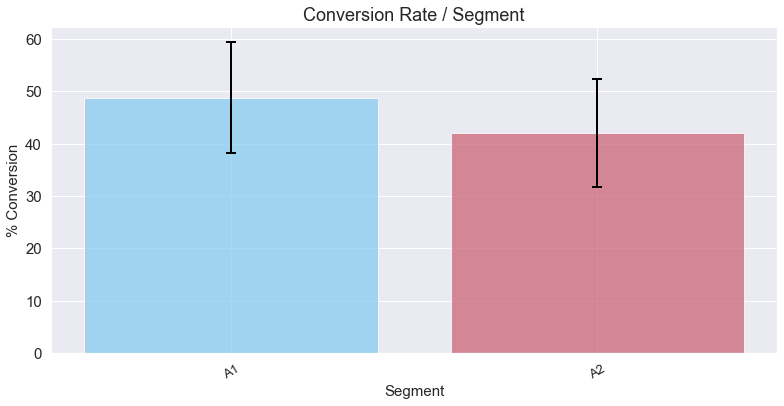

In [154]:
# визуализируем BarPlot
labels = dfp.index[:-1].tolist()
label_index = np.arange(len(labels))
values = (round(dfp['converted_proportion'][:-1]*100,2)).tolist()
half_ci = (round(dfp['standard_error'][:-1]*1.96*100,2)).tolist()
plt.subplots(figsize=(13, 6))
plt.bar(label_index, values, yerr=half_ci, alpha=0.75,
       color= color_hex_list[0:len(labels)],
       error_kw=dict(ecolor='black', lw=2, capsize=5, capthick=2))
plt.xlabel('Segment', fontsize=15)
plt.ylabel('% Conversion', fontsize=15)
plt.xticks(label_index, labels, fontsize=13, rotation=30)
plt.yticks(fontsize=15)
plt.title('Conversion Rate / Segment', fontsize=18)
plt.show()

# ТЕСТИРОВАНИЕ МОДЕЛИ ЛОКАЛЬНО

## 2 Sample

*Тип теста: z-test*


- H0: Нет разницы между сегментами и уровнем конверсии
- H1: Есть разница между сегментами и уровнем конверсии

!-> A1 - основная, старая модель, все остальные это новые "челленджеры"

In [155]:
variation1 = 'A1'
variation2 = 'A2'

### Расчет параметров по каждому сегменту

In [156]:
x1 = dfp.loc[variation1]['converted']
n1 = dfp.loc[variation1]['traffic']
x2 = dfp.loc[variation2]['converted']
n2 = dfp.loc[variation2]['traffic']

print(variation1, 'Converted:', x1)
print(variation1, 'Traffic:', n1)
print(variation2, 'Converted:', x2)
print(variation2, 'Traffic:', n2)

A1 Converted: 42.0
A1 Traffic: 86.0
A2 Converted: 37.0
A2 Traffic: 88.0


### Сравнение результатов

In [157]:
p1 = x1/n1
p2 = x2/n2
p = (x1+x2)/(n1+n2)
print('Кол-во (', variation1 ,'): {0:.2f}%'.format(100*p1))
print('Кол-во (', variation2 ,'): {0:.2f}%'.format(100*p2))
print('Среднее кол-во по всем группам: {0:.2f}%'.format(100*p))
print('% разница между группами: {0:.2f}%'.format(100*(p2-p1)))
print('% относительная разница между группами: {0:.2f}%'.format(100*(p2-p1)/p1))


var = p*(1-p)*(1/n1+1/n2)
se = math.sqrt(var)
print('\nVariance: {0:.4f}%'.format(100*var))
print('Standard Error: {0:.2f}%'.format(100*se))

z = (p1-p2)/se
pvalue = 1-stats.norm.cdf(abs(z))
pvalue *= 2-one_sided
print('\nz-stat: {z}'.format(z=z))
print('p-value: {p}'.format(p=pvalue))

Кол-во ( A1 ): 48.84%
Кол-во ( A2 ): 42.05%
Среднее кол-во по всем группам: 45.40%
% разница между группами: -6.79%
% относительная разница между группами: -13.91%

Variance: 0.5699%
Standard Error: 7.55%

z-stat: 0.8996463724803273
p-value: 0.184154235386902


### Фиксирование разниц

In [158]:
m_proportion = abs(min((1-p1),(1-p1))-1)
min_detectable_effect_size = measurable_effect_size(min([n1, n2]), alpha_Zscore, beta_Zscore, m_proportion)
print("Для текущего размера группы {n} и с baseline {m:.2f},\nмы можем получить разницу в {e:.2f}%."
      .format(n = min([n1, n2]), m = m_proportion, e=min_detectable_effect_size*100))
print('\n')


n1 = sample_size(p2-p1, alpha_Zscore, beta_Zscore, baseline_probability)
print("Разница {d:.2f}%, которая требуется для минимальной группы {n_needed}"
      .format(d=abs(100*(p2-p1)), n_needed = round(n1,0)))
print('\n')

print("Alpha - {a:.2f}\nBeta - {b:.2f}".format(a = alpha_Zscore, b = beta_Zscore))

Для текущего размера группы 86.0 и с baseline 0.49,
мы можем получить разницу в 18.95%.


Разница 6.79%, которая требуется для минимальной группы 241.0


Alpha - 1.64
Beta - 0.84


**Нужно ли больше данных?**

In [159]:
abs(p2-p1) >= min_detectable_effect_size

if abs(p2-p1) >= min_detectable_effect_size:
    print("Нет, данных достаточно для определения значимости")
else:
    print("Да, мы должны получить больше данных для определения значимости изменений")

Да, мы должны получить больше данных для определения значимости изменений


####  Интерпритация результатов

! -> Только, если больше не нужно больше данных

In [160]:
print('p-value {p} меньше, чем alpha, {alpha}?\n'.format(p=round(pvalue,5), alpha=alpha))
if (pvalue < alpha):
    print('p-value меньше, чем alpha, 0-гипотеза отвергается (null-hypothesis = no difference)')
else: 
    print('Нет, 0-гипотеза не может быть отвергнута')

p-value 0.18415 меньше, чем alpha, 0.05?

Нет, 0-гипотеза не может быть отвергнута


### Доверительный интервал - для эффективного размера группы

In [161]:
# z-statistics
z_critical = stats.norm.ppf(1-alpha*(1-0.5*(1-one_sided)))

# верхний и нижний уровень значимости
ci_low = (p2-p1) - z_critical*se
ci_upp = (p2-p1) + z_critical*se

print(' 95% Confidence Interval = ( {0:.2f}% , {1:.2f}% )'
      .format(100*ci_low, 100*ci_upp))

 95% Confidence Interval = ( -19.21% , 5.63% )


### Stats Model Formula

2х хвостовой тест

In [162]:
counts = np.array([x1, x2])
nobs = np.array([n1, n2])

stat, pval = proportions_ztest(counts, nobs, alternative = 'smaller')
print('z-stat: {0:.4f}'.format(stat))
print('p-value: {0:.8f}'.format(pval))

z-stat: -4.6325
p-value: 0.00000181


#### Extra

In [163]:
# 2х хвостовой тест результат
pvalue = 1-stats.norm.cdf(abs(z))
pvalue *= 2-False
print('p-value: {p}'.format(p=pvalue))

p-value: 0.368308470773804


In [164]:
# 1 хвостовой тест
pvalue = 1-stats.norm.cdf(abs(z))
pvalue *= 2-True
print('p-value: {p}'.format(p=pvalue))

p-value: 0.184154235386902


## 2+ Sample Proportion

*Тип теста: Chi Square*

**Гипотезы**

- H0: Нет разницы между сегментами и уровнем конверсии
- H1: Есть разница между сегментами и уровнем конверсии 

### Main Question: 

Есть разница между моделями (сегментами)? 

In [165]:
# Повторю загрузку для добавления сегментов
file_name = 'Data/sd.csv'
date_sort = 'date_visit'
data = pd.read_csv(file_name,
                  converters= {date_sort: pd.to_datetime} )

df = data.copy()
df = df.sort_values(date_sort, ascending = True)
df = df[df['version'].isin(['A1', 'A2','B', 'C'])]

traffic_label = 'clicked'
conversion_label = 'liked'
user_label = 'user_id'
date_label = 'date_visit'
segment_label = 'version'
segment_list = list(df[segment_label].unique())
variations = len(segment_list)

aggregation_column = [traffic_label, conversion_label]
traffic = []
conversions = [] 

for i in range(variations):
    v, c = df[df[segment_label] == segment_list[i] ][aggregation_column[:2]].sum()
    
    traffic.append(v)
    conversions.append(c)
    
dfp_simple = pd.DataFrame({
    "converted": conversions,
    "traffic": traffic}, 
    index = segment_list)


dfp = dfp_simple.copy().sort_index()
dfp.loc['Total'] = dfp.sum()
dfp['not_converted'] = dfp['traffic'] - dfp['converted']
proportion = dfp.converted/dfp.traffic
dfp['converted_proportion'] = proportion
dfp['standard_error'] = ((proportion * (1-proportion))/dfp.traffic)**(.5)
n = dfp.loc['Total']['traffic']
dfp['population_percentage'] = dfp['traffic']/n
dfp

,converted,traffic,not_converted,converted_proportion,standard_error,population_percentage
A1,42,86,44,0.488372,0.053902,0.248555
A2,37,88,51,0.420455,0.052621,0.254335
B,48,92,44,0.521739,0.052079,0.265896
C,37,80,43,0.462500,0.055744,0.231214
Total,164,346,182,0.473988,0.026844,1.000000


In [166]:
dfpTo = dfp[['converted', 'not_converted', 'traffic']].T
dfpTo

,A1,A2,B,C,Total
converted,42,37,48,37,164
not_converted,44,51,44,43,182
traffic,86,88,92,80,346


### % пропорций (вероятности)

In [167]:
dfpTe = dfpTo.copy()

# заменим вероятностями
for i in range(variations):
    for j in range(0, 2):
        dfpTe.iloc[j,i] = (dfpTo.loc['traffic'][i]*dfpTo['Total'][j])/n

### Chi Square / p-value

In [168]:
o = dfpTo.drop(dfpTo.columns[-1], axis = 1)[:-1]
e = dfpTe.drop(dfpTe.columns[-1], axis = 1)[:-1]

ss = (o-e)**2/e
ch2 = ss.values.sum()
ch2

1.9666036399234188

In [169]:
# P-value (степень свободы - 1)
pvalue_chi = 1 - stats.chi2.cdf(ch2, variations-1)
pvalue_chi

0.5793670974852936

#### Интерпретация результатов

In [170]:
print('p-value {p} меньше, чем alpha, {alpha}?\n'.format(p=round(pvalue_chi,5), alpha=alpha))
if (pvalue < alpha):
    print('p-value меньше, чем alpha, 0-гипотеза отвергается (null-hypothesis = no difference)')
else: 
    print('Нет, 0-гипотеза не может быть отвергнута')

p-value 0.57937 меньше, чем alpha, 0.05?

Нет, 0-гипотеза не может быть отвергнута


---

### Main Question: 
Какая модель (сегмент) лучше?

### Marascuilo Procedure (аналог Tukey-Kramer Test)

О тесте: [ссылка](https://www.itl.nist.gov/div898/handbook/prc/section4/prc474.htm)


In [171]:
# списки итерации
prp = list(dfp_simple['converted']/dfp_simple['traffic'])
vis = list(dfp_simple['traffic'])
seg = list(dfp_simple.index.values)

# Хи2
c2 = stats.chi2.cdf(ch2, variations-1)

# списки для заполнения в цикле
diff = []
critical_value = []
segment1 = []
segment2 = []
proportion1 = []
proportion2 = []
segment1_size = []
segment2_size = []
smallest_measurable_effect_size = []

In [172]:
# Парное сравнение сегментов (моделей)
# Перебор всех со всеми
for i in range(0,(variations)):
    for j in range((i+1),variations):
        segment1.append(seg[i])
        segment2.append(seg[j])
        
        proportion1.append(prp[i])
        proportion2.append(prp[j])
        
        segment1_size.append(vis[i])
        segment2_size.append(vis[j])
        smaller_sample_size = min(vis[i], vis[j])
        max_proportion = abs(min((1-prp[i]),(1-prp[j]))-1)
        es = measurable_effect_size(smaller_sample_size, alpha_Zscore, beta_Zscore, max_proportion)
        smallest_measurable_effect_size.append(es)

        d = prp[i]-prp[j]
        diff.append(d)
    
        cr = math.sqrt(c2)*math.sqrt(prp[i]*(1-prp[i])/vis[i] + prp[j]*(1-prp[j])/vis[j])
        critical_value.append(cr)


In [173]:
# Создаем DataFrame на основе вычислений
dfm = []
dfm = pd.DataFrame({
    "segment1" : segment1,
    "segment2" : segment2,
    "segment1_size": segment1_size,
    "segment2_size": segment2_size,
    "proportion1": proportion1,
    "proportion2": proportion2,
    "smallest_measurable_effect_size": smallest_measurable_effect_size,
    "diff": diff,
    "critical_value": critical_value
})

### Определим значимость

Необходимые переменные:
- alpha 
- beta 
- размер теста
- эффективный размер сегмента для теста

In [174]:
# сделаем фильтр всех результатов
dfm['significant'] = (abs(dfm['diff']) > dfm['critical_value'])
# определим финальный фильтр для таблицы
dfm['signficant_effect_size'] = ( (abs(dfm['diff']) > dfm['critical_value']) & ( dfm['diff'] >= 
                                 dfm['smallest_measurable_effect_size']) )
    
# обозначим наименование колонок
column_order = ['segment1', 'proportion1', 'segment2', 'proportion2', 'diff', 'smallest_measurable_effect_size',
                'critical_value', 'significant', 'signficant_effect_size']

# сортировка по наибольшему стат.эффекту
dfm[column_order].sort_values(['diff', 'signficant_effect_size'], ascending = [False, True])

,segment1,proportion1,segment2,proportion2,diff,smallest_measurable_effect_size,critical_value,significant,signficant_effect_size
2,B,0.521739,A2,0.420455,0.101285,0.187248,0.048017,True,False
5,A1,0.488372,A2,0.420455,0.067918,0.189541,0.048855,True,False
0,B,0.521739,C,0.462500,0.059239,0.196387,0.049477,True,False
4,C,0.462500,A2,0.420455,0.042045,0.196019,0.049717,False,False
1,B,0.521739,A1,0.488372,0.033367,0.189413,0.048610,False,False
3,C,0.462500,A1,0.488372,-0.025872,0.196520,0.050291,False,False


### Какая модель имеет статистическую значимость?

In [175]:
dfm[dfm['signficant_effect_size'] == True][['segment1', 'segment2']]

,segment1,segment2


---

#### Вывод: 

Все новые модели не имееют значительного улучшения и не могут быть приняты. 

Модель A2 имеет потенциал. 